In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/welldata.csv')
df.shape, df.head()


In [8]:
missing_data = df.isna().sum()
missing_percentages = missing_data.sort_values(ascending=False)/len(df)*100
print(missing_percentages)

DTS_1         71.813677
NPHI_1        59.100099
RHOB_1        57.855302
GR_1          31.000991
DTP_1         11.805748
RT_1           7.849356
MD_1           0.099108
Unnamed: 0     0.000000
dtype: float64


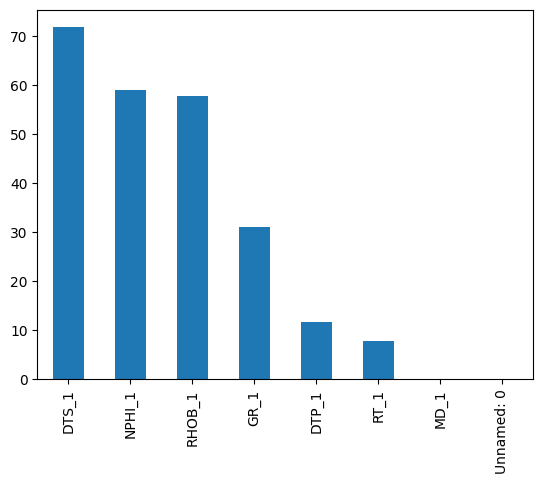

In [9]:
missing_percentages.plot(kind='bar')
plt.show()

In [23]:
well_data_filled = df.fillna(df.median())
well_data_filled = well_data_filled.drop(df.columns[0], axis=1)
well_data_filled.shape, well_data_filled.head()

((25225, 7),
       DTP_1      DTS_1      GR_1  MD_1    NPHI_1      RT_1    RHOB_1
 0  78.00956  140.27458  82.04234   0.2  0.163653  9.732183  2.489045
 1  78.00956  140.27458  82.04234   0.5  0.163653  9.732183  2.489045
 2  78.00956  140.27458  82.04234   1.0  0.163653  9.732183  2.489045
 3  78.00956  140.27458  82.04234   1.5  0.163653  9.732183  2.489045
 4  78.00956  140.27458  82.04234   2.0  0.163653  9.732183  2.489045)

In [24]:
well_data_filled_missing_percentages = well_data_filled.isna().sum().sort_values(ascending=False)/len(well_data_filled)*100
print(well_data_filled_missing_percentages)

DTP_1     0.0
DTS_1     0.0
GR_1      0.0
MD_1      0.0
NPHI_1    0.0
RT_1      0.0
RHOB_1    0.0
dtype: float64


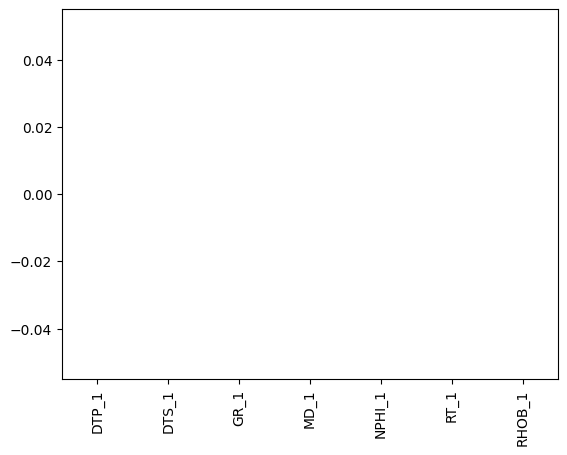

In [25]:
well_data_filled_missing_percentages.plot(kind='bar')
plt.show()

In [26]:
Q1 = well_data_filled.quantile(0.25)
Q3 = well_data_filled.quantile(0.75)
IQR = Q3 - Q1
print(IQR)


DTP_1       14.761065
DTS_1        0.000000
GR_1        14.791454
MD_1      1573.517500
NPHI_1       0.000000
RT_1        12.287362
RHOB_1       0.000000
dtype: float64


Visualize outliers using **box plots**

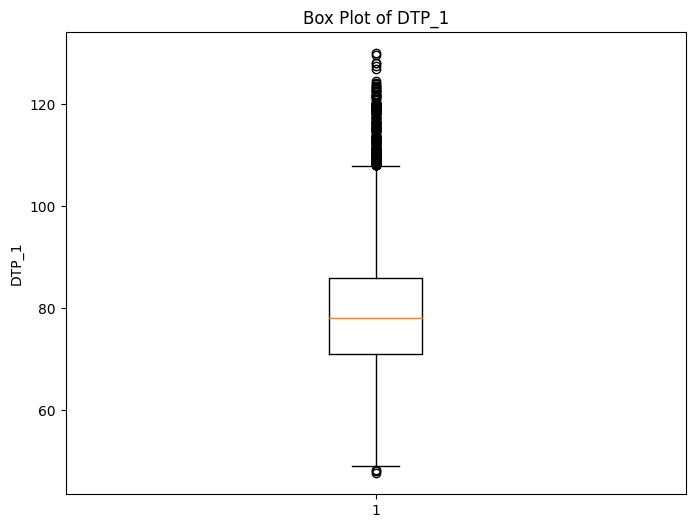

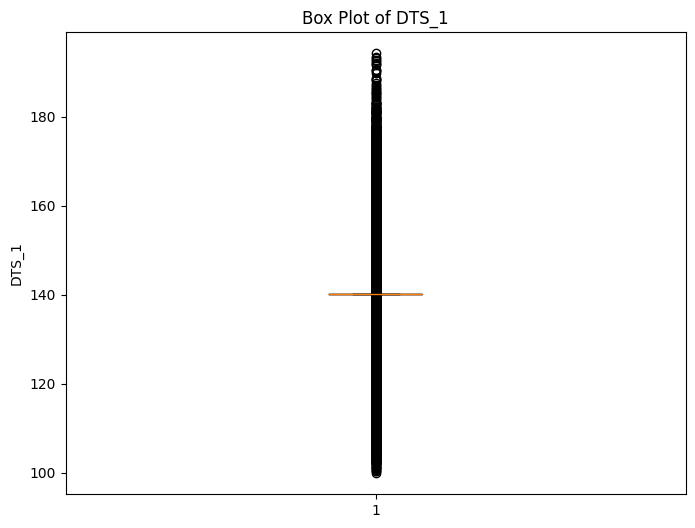

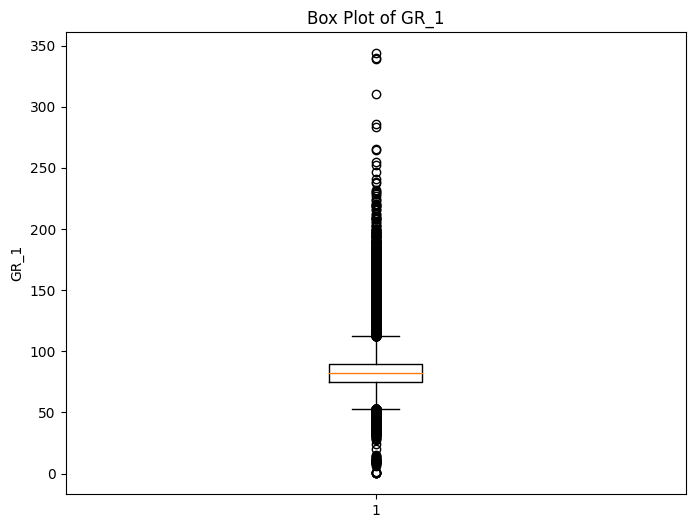

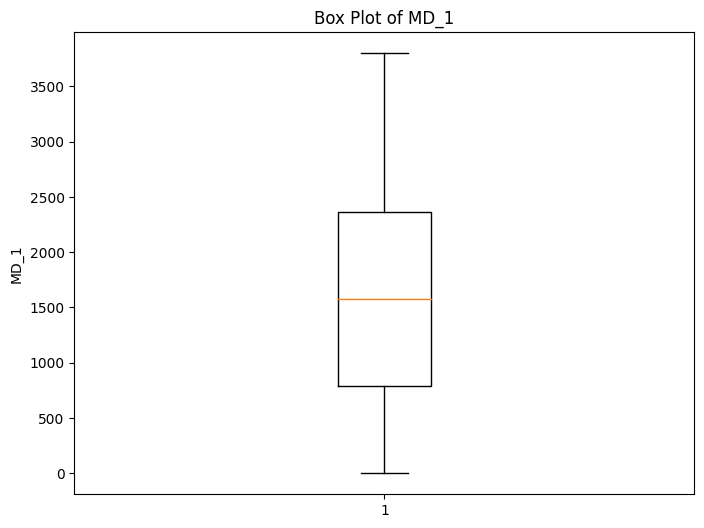

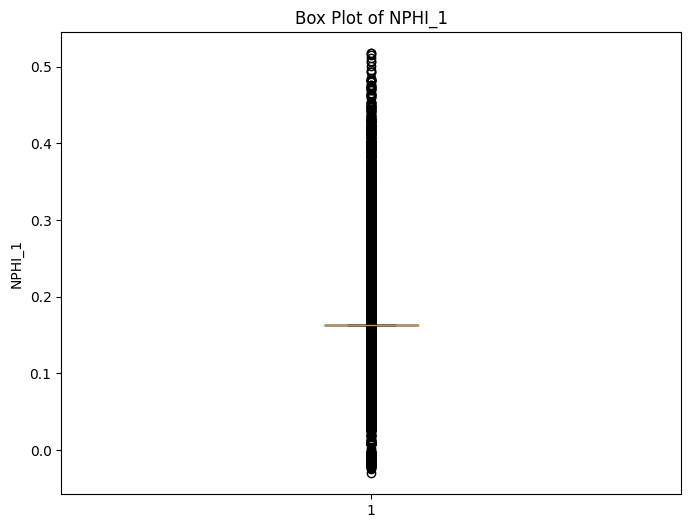

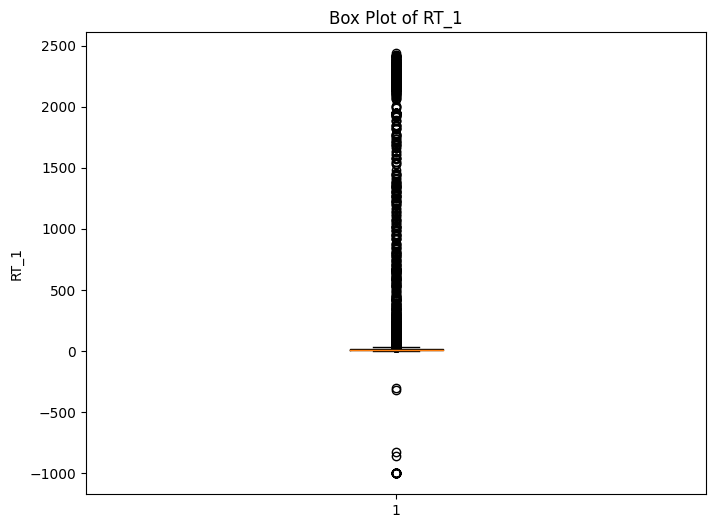

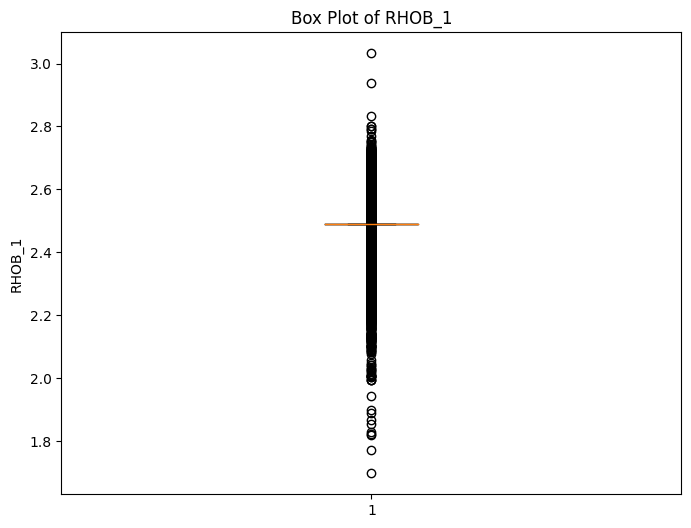

In [27]:
for column in well_data_filled.columns:
  plt.figure(figsize=(8, 6))
  plt.boxplot(well_data_filled[column])
  plt.title(f"Box Plot of {column}")
  plt.ylabel(column)
  plt.show()

Identifying outliers as points outside of 1.5*IQR

In [28]:
outliers = ((well_data_filled < (Q1 - 1.5 * IQR)) | (well_data_filled > (Q3 + 1.5 * IQR)))
print(outliers)

       DTP_1  DTS_1   GR_1   MD_1  NPHI_1   RT_1  RHOB_1
0      False  False  False  False   False  False   False
1      False  False  False  False   False  False   False
2      False  False  False  False   False  False   False
3      False  False  False  False   False  False   False
4      False  False  False  False   False  False   False
...      ...    ...    ...    ...     ...    ...     ...
25220  False  False  False  False   False   True   False
25221  False  False  False  False   False   True   False
25222  False  False  False  False   False   True   False
25223  False  False  False  False   False   True   False
25224  False  False  False  False   False   True   False

[25225 rows x 7 columns]


Isolating the rows where outliers exist for each column


In [29]:
outliers_dict = {col: well_data_filled[outliers[col]] for col in well_data_filled.columns if outliers[col].any()}

 Show a few outliers for each detected column

In [30]:

outliers_dict

{'DTP_1':             DTP_1      DTS_1      GR_1        MD_1    NPHI_1        RT_1  \
 83     108.463500  140.27458  76.37300    41.51946  0.163653    9.417367   
 216    115.163900  140.27458  74.12105   107.98277  0.163653   53.692180   
 217    128.023030  140.27458  77.59711   108.50630  0.163653   94.649376   
 218    129.663880  140.27458  79.88019   108.97510  0.163653  122.962730   
 219    128.122480  140.27458  82.58459   109.49974  0.163653  294.266140   
 ...           ...        ...       ...         ...       ...         ...   
 18453  113.176460  140.27458  82.04234   423.98670  0.163653    7.228115   
 18577  109.315210  140.27458  82.04234   486.00272  0.163653    6.567315   
 24183   48.201300  140.27458  82.04234  3289.03660  0.163653  343.422760   
 24184   47.622173  140.27458  82.04234  3289.49240  0.163653  318.587200   
 24185   48.063920  140.27458  82.04234  3290.01050  0.163653  231.630020   
 
          RHOB_1  
 83     2.337607  
 216    2.429309  
 217    

In [36]:
# Remove rows with outliers
outlier_mask = outliers.any(axis=1)
cleaned_data = well_data_filled[~outlier_mask]

# Display the shape and first few rows of the cleaned dataset
cleaned_data.shape, cleaned_data.head()

((6498, 7),
       DTP_1      DTS_1      GR_1  MD_1    NPHI_1      RT_1    RHOB_1
 0  78.00956  140.27458  82.04234   0.2  0.163653  9.732183  2.489045
 1  78.00956  140.27458  82.04234   0.5  0.163653  9.732183  2.489045
 2  78.00956  140.27458  82.04234   1.0  0.163653  9.732183  2.489045
 3  78.00956  140.27458  82.04234   1.5  0.163653  9.732183  2.489045
 4  78.00956  140.27458  82.04234   2.0  0.163653  9.732183  2.489045)

 Check the shape before and after outlier removal

In [32]:
original_shape = well_data_filled.shape
new_shape = cleaned_data.shape

original_shape, new_shape

((25225, 7), (6498, 7))

# Pair Plot for Correlation and Distribution Visualization

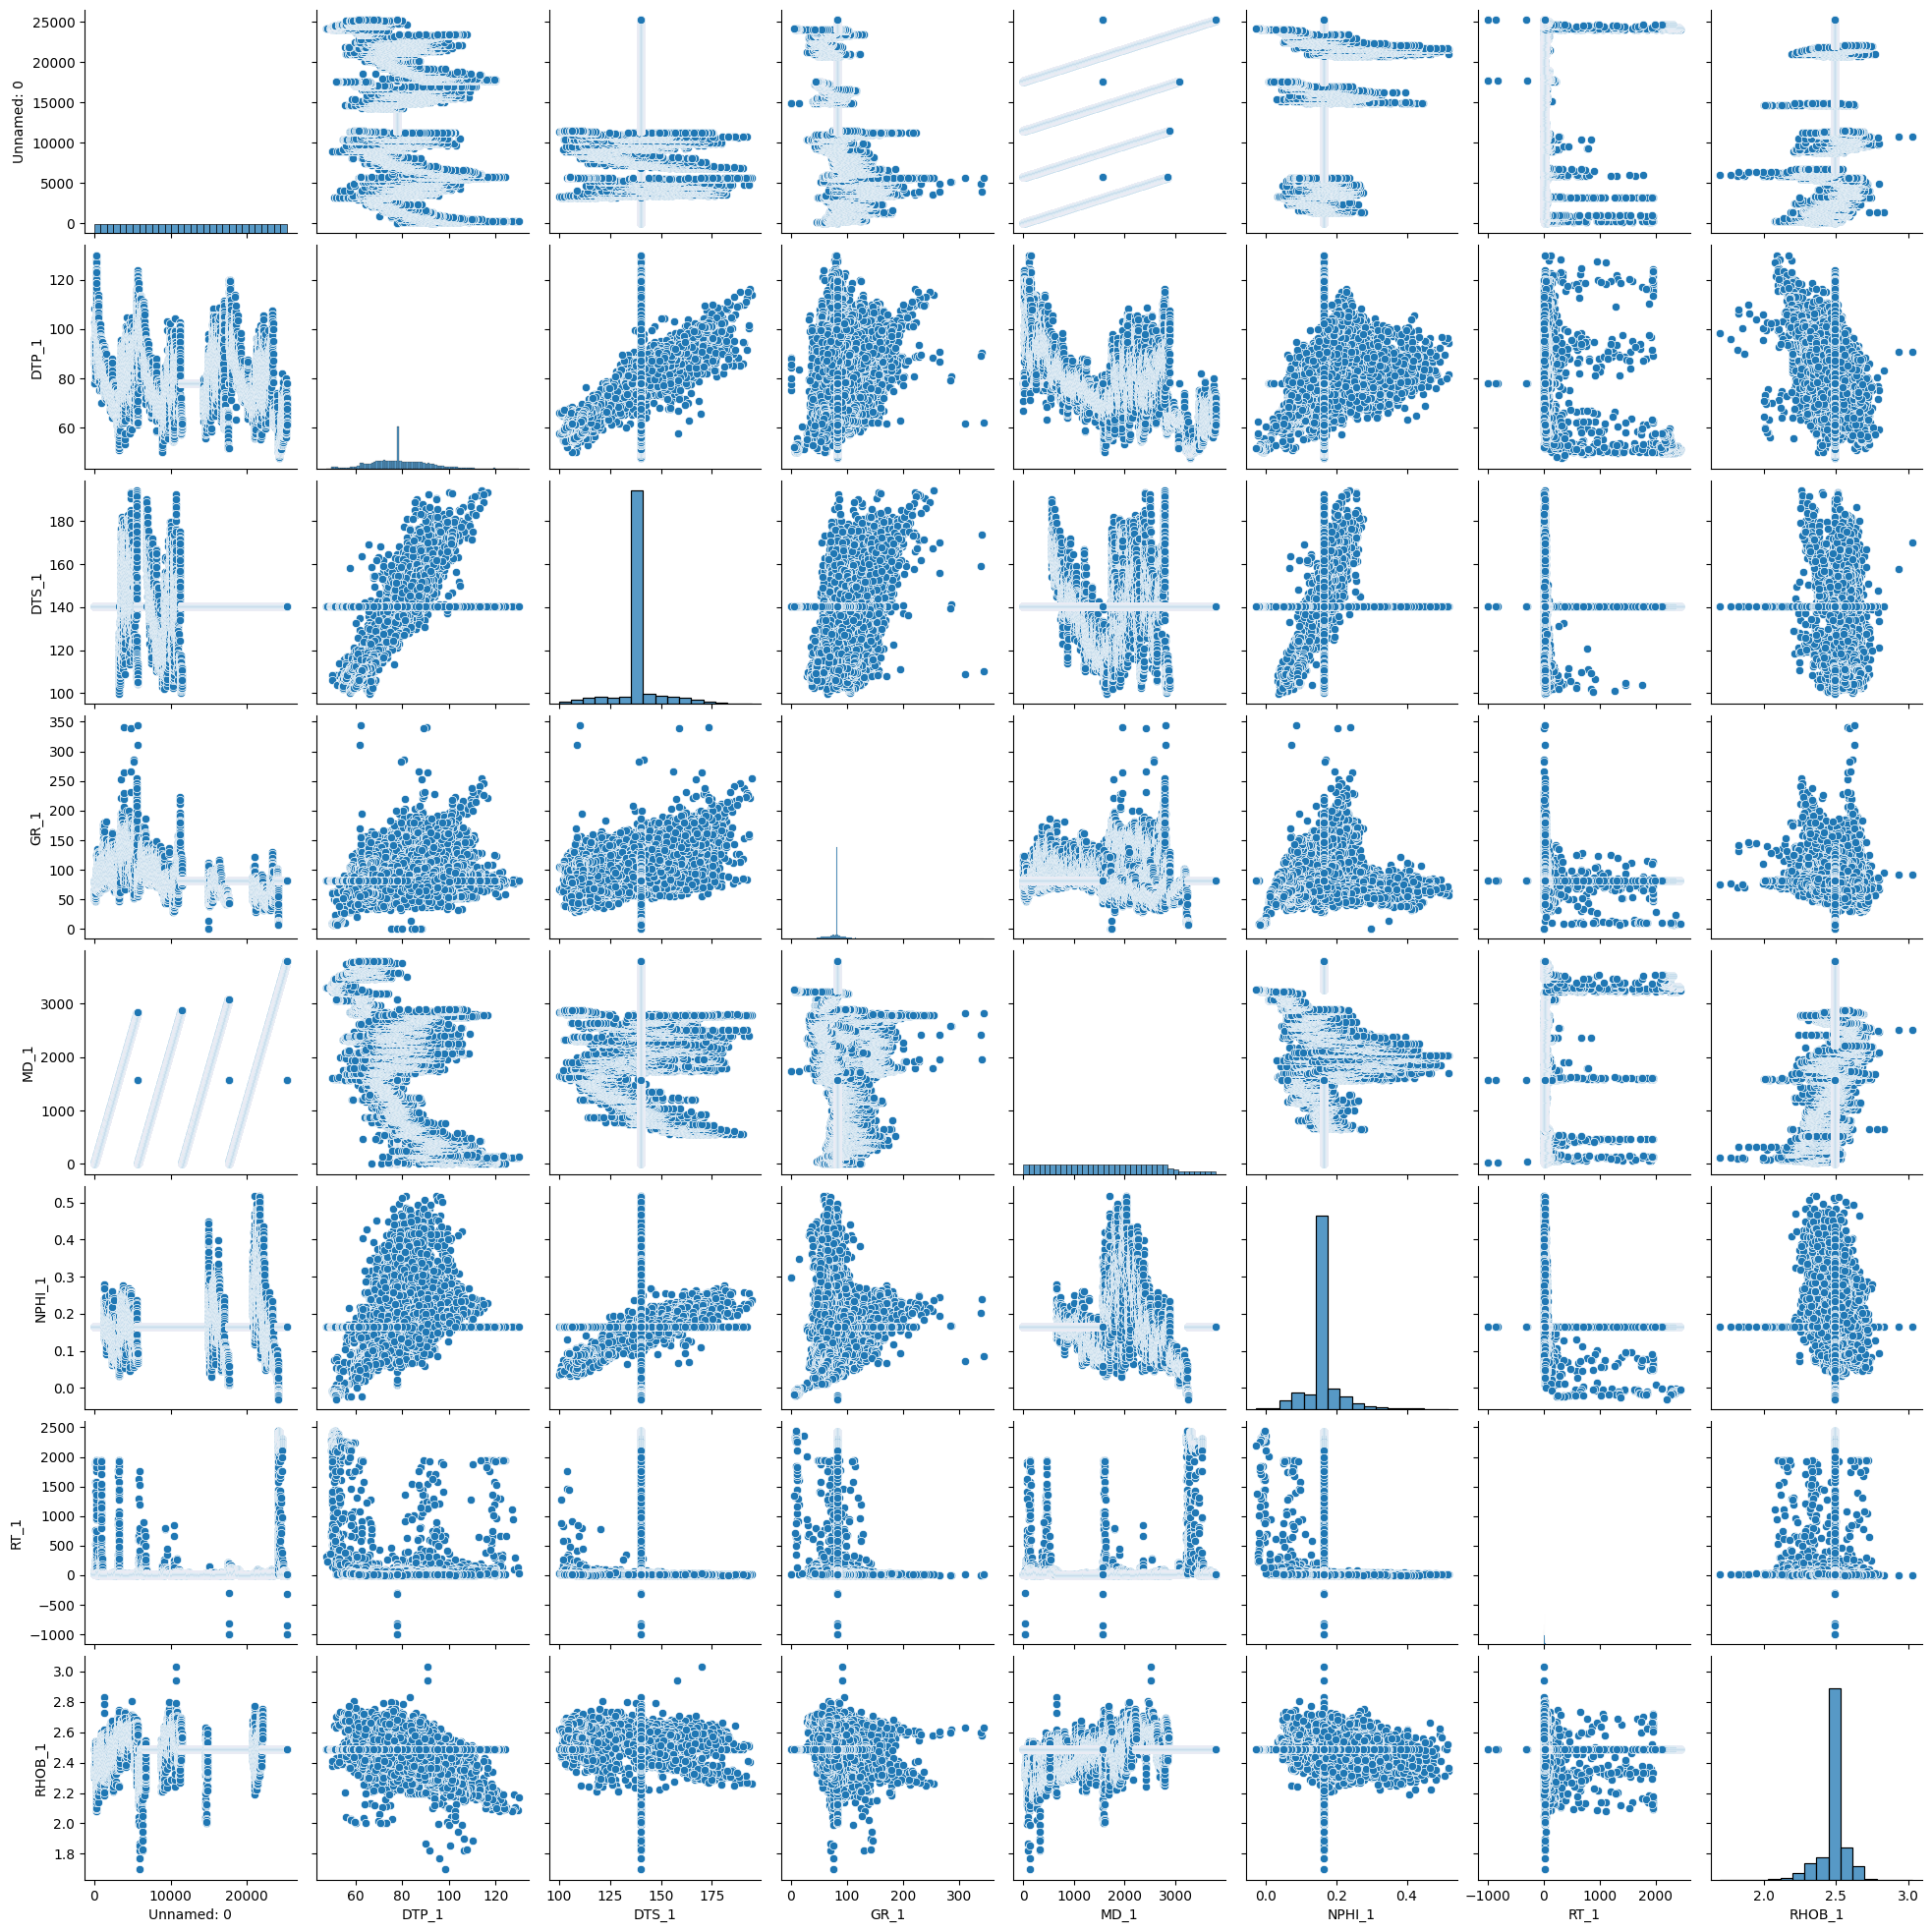

In [27]:
sns.pairplot(well_data_filled)
plt.show()

# Correlation Matrix Heatmap

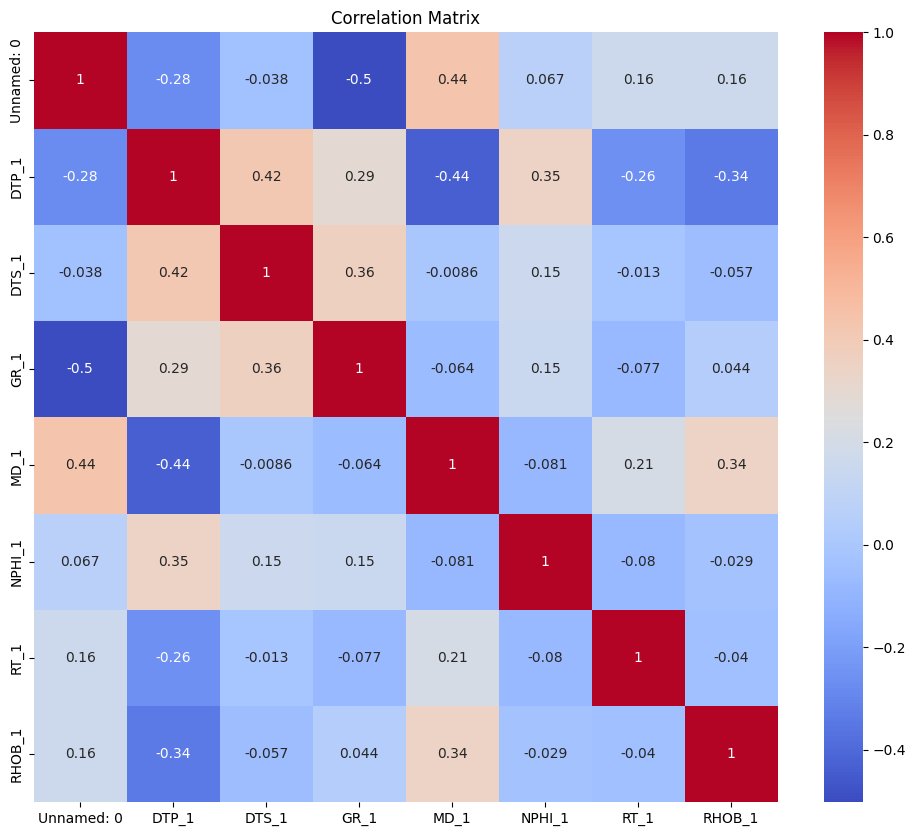

In [28]:
plt.figure(figsize=(12, 10))
sns.heatmap(well_data_filled.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# Histograms for Individual Features

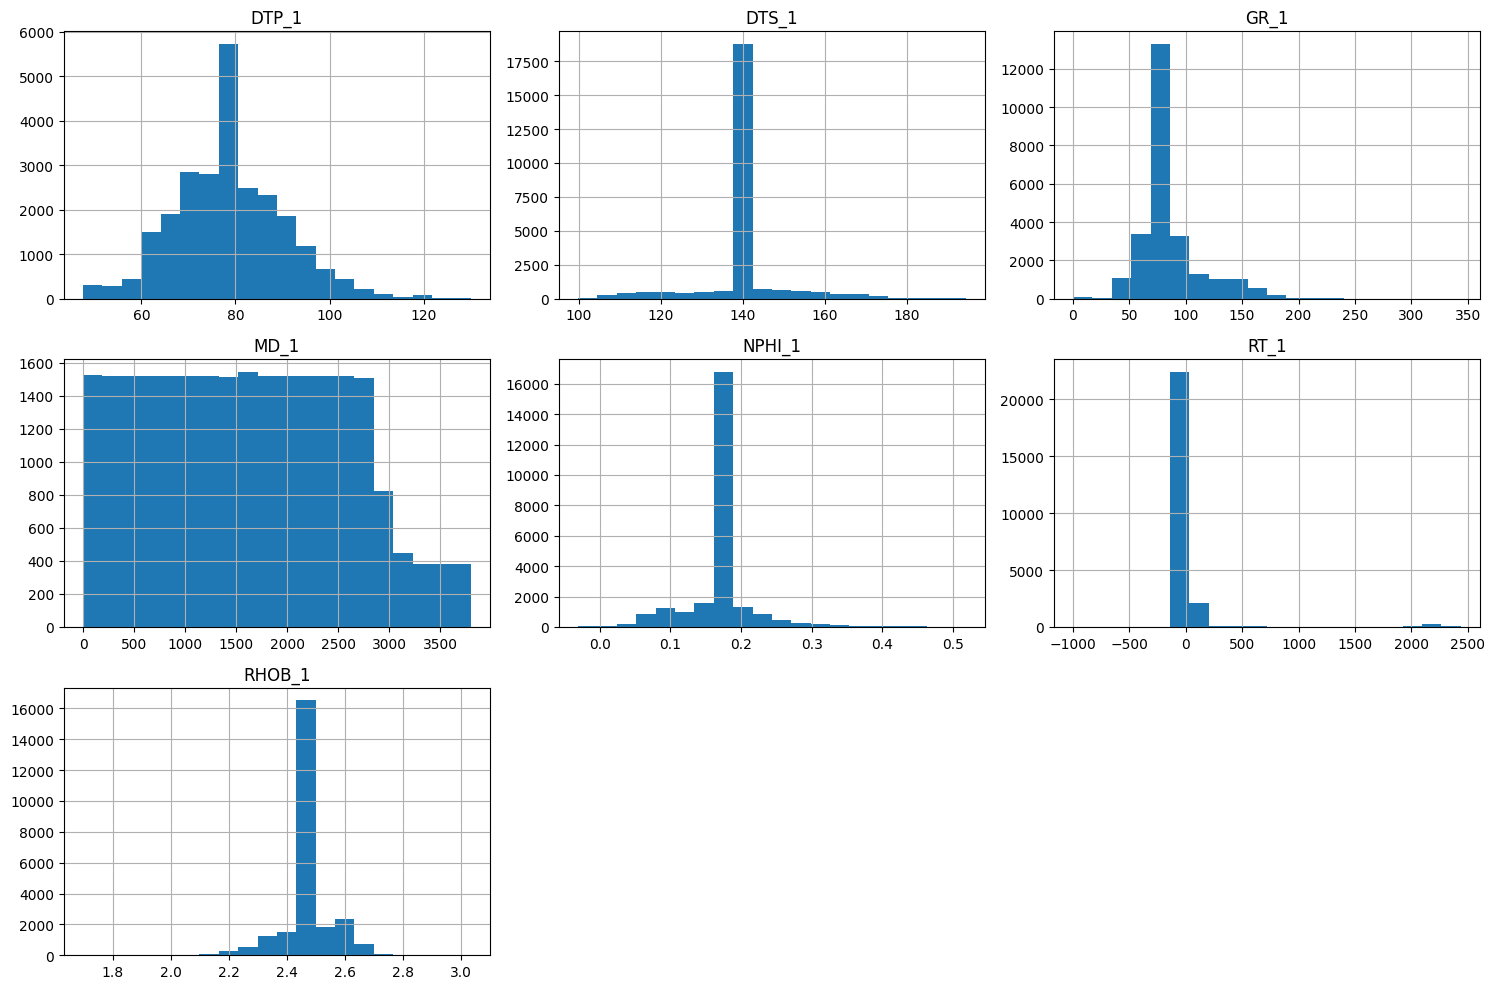

In [33]:
well_data_filled.hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.show()

In [38]:
X = cleaned_data.drop('DTP_1', axis=1)
y = cleaned_data['DTP_1']

# Split the data into training and testing sets

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an XGBoost regressor

In [40]:
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)


# Train the model

In [41]:
model.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

# Make predictions on the test set

In [42]:
y_pred = model.predict(X_test)

# Evaluate the model

In [44]:
def root_mean_squared_error(y_true, y_pred):
  """Calculates the Root Mean Squared Error (RMSE) between true and predicted values.

  Args:
    y_true: The true values.
    y_pred: The predicted values.

  Returns:
    The RMSE.
  """
  return np.sqrt(mean_squared_error(y_true, y_pred))

In [47]:
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 6.738708900961849
